In [1]:
import torch
import numpy as np
from collections import defaultdict

class TBHNN(torch.nn.Module):
    """
    Tight-binding Hamiltonian neural network
    """

    def __init__(self):
        super(TBHNN, self).__init__()
        self.H_size_added = 0
        self.std=0.1
        
    def read_training_set(self, references, k_vectors):
        num_k, num_b = references.shape
        self.num_b = num_b
        self.num_k = num_k
        self.H_size_init = num_b
        self.H_size = num_b
        self.references = torch.tensor(references, dtype=torch.float32, requires_grad=True)
        self.k_vectors = torch.tensor(k_vectors, dtype=torch.float32, requires_grad=True)
        

    
    def define_TB_representation(self, vectors_without_opposite):
        
        num_r = len(vectors_without_opposite)
        self.num_r = num_r
        self.R = torch.nn.Parameter(torch.zeros((num_r, 3), dtype=torch.float32))

        
        new_R_values = []
        for i, vector in enumerate(vectors_without_opposite):
            if not np.all(np.isclose(vector, 0.0)):
                new_R_values.append(torch.tensor(vector, dtype=torch.float32))
            else:
                new_R_values.append(torch.zeros(3, dtype=torch.float32))

        new_R = torch.stack(new_R_values)

        self.R = torch.nn.Parameter(new_R)

        self.R_without_opposite = vectors_without_opposite

              
        
    def reset_optimizer(self,optimizer):
        optimizer.state = defaultdict(dict)

    def einitialize(self):
        self.H_R = torch.nn.ParameterList()  
        self.H_size = self.H_size_init + self.H_size_added
        for i in self.R_without_opposite:
            H_tmp = torch.nn.Parameter(torch.randn((self.H_size, self.H_size), dtype=torch.complex64) * self.std)
            if np.sum(np.abs(i)) != 0:
                self.H_R.append(H_tmp)
                self.H_R.append(H_tmp.t())  # Transpose the matrix in PyTorch
            else:
                self.H_R.append(H_tmp + H_tmp.t())  # Ensure that H(R=[0,0,0]) is symmetric


    # Placeholder for compute_bands method, will be filled in later
    def compute_bands(self):
        reproduced_bands = torch.zeros((self.num_k, self.H_size), dtype=torch.float32)
        
        for i in range(self.num_k):
            K = torch.zeros((self.H_size, self.H_size), dtype=torch.complex64)
            for j in range(self.num_r):
                exp_factor = torch.exp(-1j * np.pi * torch.matmul(self.k_vectors[i], self.R[j]))
                K += exp_factor * self.H_R[j]
                
            # Eigenvalues are computed from the Hermitian part of K to ensure they are real
            eigenvalues, _ = torch.linalg.eigh(K + K.conj().T)
            reproduced_bands[i] = eigenvalues.real

        # Sort the bands and discard those not needed for loss computation
        reproduced_bands = reproduced_bands[:, int(self.H_size_added/2):int(self.H_size_added//2)+self.num_b]
        self.bandstructure = reproduced_bands

        return reproduced_bands

In [5]:

rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)
# Load training data
references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
k_vectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)


# Initialize the model
tbhnn = TBHNN()



def main(choosen_optimizer,lr,loss,basis_added_step,max_training_steps,threshold,fitting) :
    optimizer = choosen_optimizer(tbhnn.parameters(), lr)
    finished = fitting(optimizer, threshold,loss, max_training_steps)
    
    while finished[0] == False:
        tbhnn.H_size_added += basis_added_step
        tbhnn.einitialize()
        # tbhnn.reset_optimizer(optimizer)
        optimizer = choosen_optimizer(tbhnn.parameters(), lr)
        finished = fitting(optimizer, threshold,loss, max_training_steps)

    
    return finished[1]

def stocatstic_reset_fitting(optimizer, threshold, choosen_loss,max_training_steps):
    step=0
    number_reset=0
    global step_tot
    step_reset = int(np.random.exponential(max_training_steps))
    while step<step_reset :
        optimizer.zero_grad()
        
        # Compute the loss and perform backward pass
        reproduced_bands = tbhnn.compute_bands()
        loss=choosen_loss((reproduced_bands-tbhnn.references)**2)
        
        loss.backward()
        optimizer.step()
        loss_value=loss.item()
        # Print loss every 10 steps
        if step % 10 == 0:
            print(f"Step {step}: Loss = {loss.item()}")
           
        step+=1
        step_tot+=1
        if loss_value<threshold :
            break
    if step>=step_reset :
        number_reset+=1           
        print(f"Reseated model parameters at step {step}")
        return False,reproduced_bands
    else:
        print("Convergence reached.")
        return True, reproduced_bands
    


In [6]:
torch.set_default_device("cpu")

max_training_steps= 1500


basis_added_step = 2
threshold = 1e-4
learning_rate=0.01
std=0.1

tbhnn.__init__()
tbhnn.read_training_set(references, k_vectors)
tbhnn.define_TB_representation(rvectors_without_opposite)
step_tot=0
tbhnn.std=std
tbhnn.einitialize()
optimizer = torch.optim.Adam
loss = torch.mean
reproduce_band=main(optimizer,learning_rate,loss,basis_added_step,max_training_steps,threshold,stocatstic_reset_fitting)

Step 0: Loss = 1.3098771572113037
Step 10: Loss = 0.5549634099006653
Step 20: Loss = 0.2523452043533325
Step 30: Loss = 0.08849179744720459
Step 40: Loss = 0.01993708498775959
Step 50: Loss = 0.006411426700651646
Step 60: Loss = 0.00473614688962698
Step 70: Loss = 0.0028771122451871634
Step 80: Loss = 0.0020883288234472275
Step 90: Loss = 0.0014937432715669274
Step 100: Loss = 0.001287149963900447
Step 110: Loss = 0.001128031755797565
Step 120: Loss = 0.001002081437036395
Step 130: Loss = 0.0009064692421816289
Step 140: Loss = 0.0008280971669591963
Step 150: Loss = 0.0007631099433638155
Step 160: Loss = 0.000708247534930706
Step 170: Loss = 0.000661227386444807
Step 180: Loss = 0.0006205844110809267
Step 190: Loss = 0.0005850776797160506
Step 200: Loss = 0.0005537606193684042
Step 210: Loss = 0.0005259037134237587
Step 220: Loss = 0.0005009605083614588
Step 230: Loss = 0.0004785089404322207
Step 240: Loss = 0.0004582022374961525
Step 250: Loss = 0.0004397474694997072
Step 260: Loss = 0

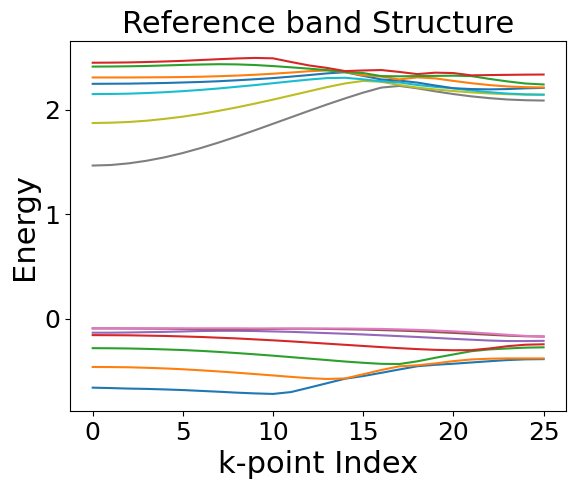

In [7]:
import matplotlib.pyplot as plt

# Convert the tensor to a NumPy array if it's not already (and detach it from the computation graph if it requires grad)
original_bands_np = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
# Assuming the horizontal axis is the band index and the vertical axis is the energy
for band in range(original_bands_np.shape[1]):
    plt.plot(original_bands_np[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index',fontsize='22')
plt.ylabel('Energy',fontsize='22')
plt.title('Reference band Structure',fontsize='22')
plt.tick_params(labelsize=18)
plt.show()

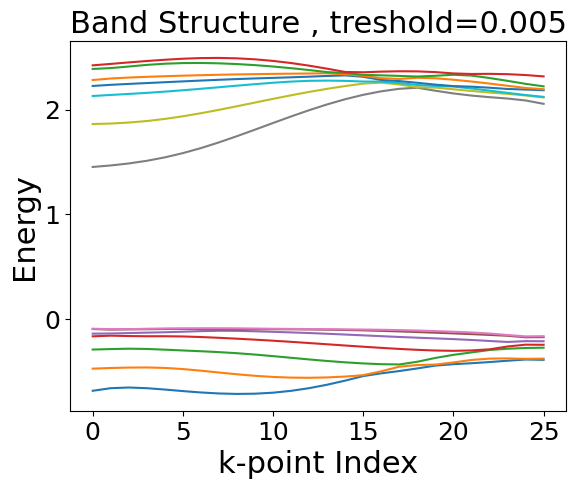

In [9]:
# Convert the tensor to a NumPy array if it's not already (and detach it from the computation graph if it requires grad)
reproduced_bands_np = reproduce_band.detach().numpy()

# Assuming the horizontal axis is the band index and the vertical axis is the energy
for band in range(reproduced_bands_np.shape[1]):
    plt.plot(reproduced_bands_np[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index',fontsize='22')
plt.ylabel('Energy',fontsize='22')
plt.title('Band Structure , treshold=0.005',fontsize='22')
plt.tick_params(labelsize=18)
plt.show()